### 라이브러리 선언

In [1]:
import numpy as np
import  pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score # 평가를 위함
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

### 재현율, 정밀도 그래프

In [2]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

### 평가 함수

In [3]:
# 오차 행렬 : 예측, 실제값에 대한 수치를 행렬로 표현
# 정확도 : 정확의 정도
# 정밀도 : 암걸렸다고 예측했을때(1) 실제 암걸렸을 확률(1)
# 재현율 : 암걸린사람이(1) 암걸렸다고(1) 판단할 확률
# F1 : 정밀도 , 재현율은 둘다 높을 수록 좋으므로 한쪽으로 치우치지 않는 정도를 나타냄 (1일수록 좋음)
# ROC&AUC : ROC 곡선은 FPR을 0에서 1로 변화 할 때 TNR의 변화 값. ROC 곡선 아래 면적이 1에 가까울 수록 좋은데 면적의 크기를 AUC라 부른다.
# > FPR: 당뇨병 환자를 당뇨병 환자로 예측하는 확률
# > TNR : 비 당뇨병 환자를 비 당뇨병 환자로 예측하는 확률
# > TNR 보다 FPR 를 정확히 예측하는게 여기서는 중요! (당뇨병 환자를 잘못예측하면 치료 못해 죽을 수 있지만, 비 당뇨병 환자를 잘못 예측 하면 재 검사비만 들뿐. 죽지는 않음.)
# y_test 는 정답 데이터(0 or 1) , pred 는 예측 데이터(0 or 1)
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬 (평가 지표)
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1 (정밀도, 재현율 적정 수준 : 1에 가까울 수록 좋음)
    roc_auc = roc_auc_score(y_test, pred_proba) # AUC (1에 가까울 수록 좋음)
    
    print('오차 행렬\n {}'.format(confusion))
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC: {4:.4f}'
         .format(accuracy, precision, recall, f1, roc_auc))

### 임곗값에 따른 평가

In [4]:
# Binarizer : threshold 가 0.3이라면, 0.3보다 크면 1 , 작거나 같으면 0으로 출력
# 임곗값 : 0과 1로 예측하는 기준 : 분류 모델(LogisticRegression)은 기본 임곗값이 0.5이다.
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)  
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

## 피마 인디언 당뇨병 예측
-- https://www.kaggle.com/uciml/pima-indians-diabetes-database
- Pregnancies                 임신 횟수
- Glucose                     포도당 수치
- BloodPressure               혈압
- SkinThickness               피하지방
- Insulin                     인슐린 수치
- BMI                         체질량 수치
- DiabetesPedigreeFunction    당뇨 내력 가중치
- Age                         나이
- Outcome                     결과 (0: 정상 | 1: 당뇨병)

In [5]:
diabetes_data = pd.read_csv("data/diabetes.csv")

In [6]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
# 0 : 죽음 | 1: 산다
diabetes_data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [8]:
# null 값이 없음
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
x_data = diabetes_data.iloc[:,:-1]
y_data = diabetes_data.iloc[:,[-1]]

In [10]:
# test_size=0.2 : 테스트 데이터를 20% 로 만든다.
# random_state : 실행 시킬때마다 데이터 셋이 바뀌지 않게 시드값 정의, 아무 숫자나 가능 
# startify=y_data : 데이터 비율 그대로 학습, 테스트 데이터 분배
x_train, x_test , y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=94, stratify=y_data)

In [11]:
model = LogisticRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)
pred_proba = model.predict_proba(x_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
 [[89 11]
 [28 26]]
정확도 : 0.7468, 정밀도 : 0.7027, 재현율 : 0.4815, F1 : 0.5714, AUC: 0.7620


/Users/hongyoolee/miniconda3/envs/study/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/hongyoolee/miniconda3/envs/study/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


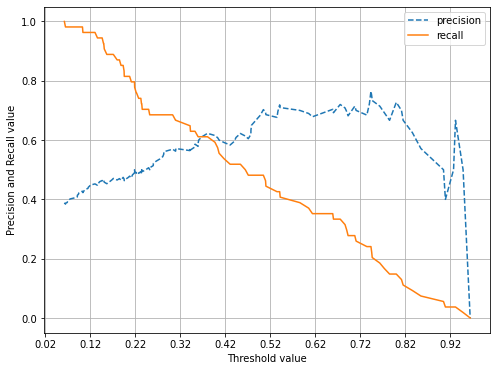

In [12]:
pred_proba_c1 = model.predict_proba(x_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

###  데이터 전처리

In [13]:
# min 이 0 인 데이터가 이상함. > 예를들어 포도당 수치가 0인것
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

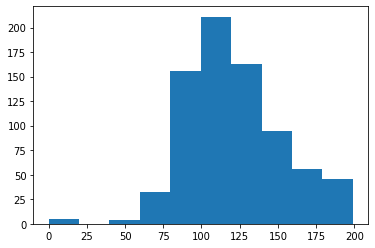

In [14]:
# 0인 데이터가 어느정도 있는지 봄.
plt.hist(diabetes_data['Glucose'], bins=10)

In [15]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [16]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, diabetes_data[zero_features].mean())

## 재 검토

In [17]:
x_data = diabetes_data.iloc[:,:-1]
y_data = diabetes_data.iloc[:,[-1]]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(x_data)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data, test_size = 0.2, random_state = 156, stratify=y_data)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
model = LogisticRegression()
model.fit(X_train , y_train)
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
 [[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1 : 0.6804, AUC: 0.8433


/Users/hongyoolee/miniconda3/envs/study/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### 임곗값에 따른 평가 지표 값

In [18]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = model.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
 [[67 33]
 [11 43]]
정확도 : 0.7143, 정밀도 : 0.5658, 재현율 : 0.7963, F1 : 0.6615, AUC: 0.8433
임곗값: 0.33
오차 행렬
 [[72 28]
 [12 42]]
정확도 : 0.7403, 정밀도 : 0.6000, 재현율 : 0.7778, F1 : 0.6774, AUC: 0.8433
임곗값: 0.36
오차 행렬
 [[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도 : 0.6190, 재현율 : 0.7222, F1 : 0.6667, AUC: 0.8433
임곗값: 0.39
오차 행렬
 [[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도 : 0.6333, 재현율 : 0.7037, F1 : 0.6667, AUC: 0.8433
임곗값: 0.42
오차 행렬
 [[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도 : 0.6923, 재현율 : 0.6667, F1 : 0.6792, AUC: 0.8433
임곗값: 0.45
오차 행렬
 [[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667, F1 : 0.6857, AUC: 0.8433
임곗값: 0.48
오차 행렬
 [[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, F1 : 0.6931, AUC: 0.8433
임곗값: 0.5
오차 행렬
 [[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1 : 0.6804, AUC: 0.8433


###  최적의 임곗값으로 예측

In [19]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 

get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
 [[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, F1 : 0.6931, AUC: 0.8433
